# Import

In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
# Prevent Keras info message; "Using TensorFlow backend."
STDERR = sys.stderr
sys.stderr = open(os.devnull, "w")
sys.stderr = STDERR
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
df = df.reset_index(drop=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

# Handle imbalance dataset
Under-sampling technique

In [4]:
class_0_df = df[df['Class'] == 0].sample(n=2000, random_state=123)
class_1_df = df[df['Class'] == 1]

balanced_df = class_0_df.append(class_1_df, ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=123).reset_index(drop=True)
balanced_df.groupby('Class').size()

Class
0    2000
1     492
dtype: int64

# Train-Test split

In [5]:
def train_size(num):
    x_train = balanced_df[balanced_df.columns.difference(['Class'])][:num]
    y_train = balanced_df['Class'][:num]
    return x_train.values, to_categorical(y_train.values, num_classes=2)

x_train, y_train = train_size(2000)
x_test, y_test = train_size(2400)
x_test = x_test[2000:2400]; y_test = y_test[2000:2400]

# Define SOM model
from https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/

In [6]:
class SOM(object):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
 
        #Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        ##INITIALIZE GRAPH
        self._graph = tf.Graph()
 
        ##POPULATE GRAPH WITH NECESSARY COMPONENTS
        with self._graph.as_default():
 
            ##VARIABLES AND CONSTANT OPS FOR DATA STORAGE
 
            #Randomly initialized weightage vectors for all neurons,
            #stored together as a matrix Variable of size [m*n, dim]
            self._weightage_vects = tf.Variable(tf.random_normal(
                [m*n, dim]))
 
            #Matrix of size [m*n, 2] for SOM grid locations
            #of neurons
            self._location_vects = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
 
            ##PLACEHOLDERS FOR TRAINING INPUTS
            #We need to assign them as attributes to self, since they
            #will be fed in during training
 
            #The training vector
            self._vect_input = tf.placeholder("float", [dim])
            #Iteration number
            self._iter_input = tf.placeholder("float")
 
            ##CONSTRUCT TRAINING OP PIECE BY PIECE
            #Only the final, 'root' training op needs to be assigned as
            #an attribute to self, since all the rest will be executed
            #automatically during training
 
            #To compute the Best Matching Unit given a vector
            #Basically calculates the Euclidean distance between every
            #neuron's weightage vector and the input, and returns the
            #index of the neuron which gives the least value
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
 
            #This will extract the location of the BMU based on the BMU's
            #index
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),
                                 [2])
 
            #To compute the alpha and sigma values based on iteration
            #number
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            #Construct the op that will generate a vector with learning
            #rates for all neurons, based on iteration number and location
            #wrt BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack(
                    [bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            #Finally, the op that will use learning_rate_op to update
            #the weightage vectors of all neurons based on a particular
            #input
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects))                                         
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            ##INITIALIZE SESSION
            self._sess = tf.Session()
 
            ##INITIALIZE VARIABLES
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons
        in the SOM.
        """
        #Nested iterations over both dimensions
        #to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        """
        Trains the SOM.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Current weightage vectors for all neurons(initially random) are
        taken as starting conditions for training.
        """
 
        #Training iterations
        for iter_no in tqdm(range(self._n_iterations)):
            #Train with each vector one by one
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
 
        #Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        """
        Returns a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        """
        Maps each input vector to the relevant neuron in the SOM
        grid.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Returns a list of 1-D NumPy arrays containing (row, column)
        info for each input vector(in the same order), corresponding
        to mapped neuron.
        """
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return

# Train model

In [7]:
som = SOM(20, 20, x_train.shape[1], 50)
som.train(x_train)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 50/50 [05:37<00:00,  6.74s/it]


# Visualize

In [8]:
# Fit train data into SOM lattice
mapped = som.map_vects(x_train)
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]

index = [ str(np.where(r==1)[0][0]) for r in y_train ]

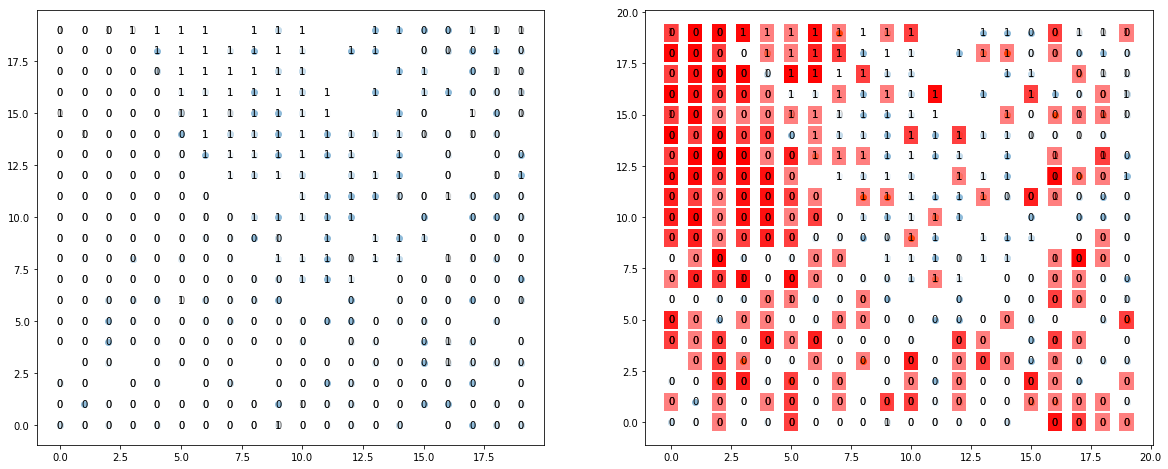

In [11]:
## Plots: 1) Train 2) Test+Train ###

# plt.title('Fraud_Detection with SOM (20x20) Train2000:Test400)')
plt.figure(1, figsize=(20,8))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

# Testing
mappedtest = som.map_vects(x_test)
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==1)[0][0] for r in y_test ]
index2 = list(map(str, index2))

plt.figure(1, figsize=(20,8))
plt.subplot(122)
# Plot 2: Training + Testing
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(x2,y2)
# Just adding text
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.savefig("Fraud_Detection_20x20.png")
plt.show()